# Meteorite Landing Classification Report


## Introduction
- Dataset: NASA Meteorite Landings (~38k rows). Target label `fall` (Fell vs Found).
- Cleaning: pure Python csv processing (no pandas); drop invalid mass/year/lat/lon; normalize labels; add `log_mass`.
- Sampling: stratified 1/3 test split for modeling; 1500-row stratified sample for EDA visualization.
- Constraints: no pandas; custom sklearn-like models (KNN, Naive Bayes, Decision Tree, Random Forest, Dummy baseline).

## Data Cleaning
- Validate mass > 0, year between 860-2025, lat/lon within valid ranges; keep Fell/Found only; compute `log_mass`.
- After cleaning: 38,094 rows, 6 usable features (mass/log_mass/year/reclat/reclong/fall/recclass).
- Stratified sample 1500 rows for plots; full set used for modeling with stratified 1/3 test split.

## Exploratory Analysis
- Figures (code cells below) cover: Fell vs Found counts; mass histogram and log-mass; recclass top-20 frequencies; geographic scatter; boxplot of log_mass by label; correlation heatmap.
- Observations: heavy class imbalance (Found >> Fell); mass highly skewed until log transform; Fell objects tend to be heavier; clear observation bias by region/year.

## Feature Preparation
- Numerical features: `log_mass`, `year`, `reclat`, `reclong`.
- Labels: `fall` (Fell/Found).
- Stratified split helper ensures 1/3 test set, 2/3 remainder for training per course requirement.

## Models and Results
- Baseline Dummy (predict Found): accuracy ~0.97 but zero recall for Fell; confusion [[0,205],[0,7413]].
- Naive Bayes (current run): accuracy ~0.95; confusion [[142,63],[287,7126]].
- Random Forest: sweep parameters (N,M,F) = (10,5,2), (20,7,2), (30,10,3); majority vote; validation selects top M trees. Cells print accuracy and confusion; pick best as final.
- Multi-run loop (5 seeds) reports mean/variance of accuracy and balanced accuracy for KNN/NB/DecisionTree/RandomForest to mitigate imbalance.
- Decision Tree full one-hot over 38k x 423 is infeasible (O(n^2 d)); experiments use 4 numeric features; note exclusion of full tree run.

## Discussion
- Class imbalance is large: evaluate with confusion matrices and balanced accuracy, not accuracy alone.
- Random Forest uses node-level random feature subset and validation top-M to improve robustness; Naive Bayes already captures some Fell cases.
- Entropy is implemented as \(-\sum p_c \log_2 p_c\) over labels, used for decision tree splits and RF base learners.

## Conclusion
- Pure-Python cleaning + stratified sampling meets no-pandas constraint and reduces scale for EDA.
- Best-performing model from RF sweep should be reported with its N/M/F and compared to single decision tree.
- Future work: richer feature engineering (geo bucketing, year bins), cost-sensitive/reshuffling for imbalance, larger RF sweeps with parallelism.

## Acknowledgments
- Data: NASA Meteorite Landings.
- Course-provided mysklearn framework and prior PA codebase.
- Custom implementations for KNN/Naive Bayes/Decision Tree/Random Forest and accompanying tests.

In [1]:
import csv

with open("Meteorite_Landings.csv", newline="", encoding="utf-8") as f:
    reader = csv.DictReader(f)
    fieldnames = reader.fieldnames
    raw_rows = [row for row in reader]

print("Raw rows:", len(raw_rows))
print("Field count:", len(fieldnames))
print("Fieldnames:", fieldnames)


Raw rows: 45716
Field count: 10
Fieldnames: ['name', 'id', 'nametype', 'recclass', 'mass (g)', 'fall', 'year', 'reclat', 'reclong', 'GeoLocation']


In [2]:
import math, re, random
from collections import Counter, defaultdict

# Extract year within [860, 2025] per course constraint
def extract_year(val):
    if val is None:
        return None
    match = re.search(r"(\d{4})", str(val))
    if match:
        year = int(match.group(1))
        if 860 <= year <= 2025:
            return year
    return None

cleaned_rows = []
for row in raw_rows:
    # Mass and log mass
    try:
        mass_val = float(row.get("mass (g)"))
    except (TypeError, ValueError):
        continue
    if mass_val <= 0:
        continue

    # Year
    year_val = extract_year(row.get("year"))
    if year_val is None:
        continue

    # Latitude/Longitude
    try:
        lat = float(row.get("reclat", ""))
        lon = float(row.get("reclong", ""))
    except (TypeError, ValueError):
        continue
    if not (-90 <= lat <= 90 and -180 <= lon <= 180):
        continue

    # Label
    fall = (row.get("fall") or "").strip().title()
    if fall not in ("Fell", "Found"):
        continue

    recclass = row.get("recclass", "")

    cleaned_rows.append({
        "mass": mass_val,
        "log_mass": math.log(mass_val),
        "year": year_val,
        "reclat": lat,
        "reclong": lon,
        "fall": fall,
        "recclass": recclass
    })

print("Rows after cleaning:", len(cleaned_rows))
fall_counts = Counter(r["fall"] for r in cleaned_rows)
print("Label distribution:", fall_counts)

# Stratified sample 1500 rows keeping Fell/Found ratio
def stratified_sample(rows, label_key, total, seed=322):
    buckets = defaultdict(list)
    for r in rows:
        buckets[r[label_key]].append(r)
    random.seed(seed)
    sampled = []
    for label, bucket in buckets.items():
        random.shuffle(bucket)
        k = max(1, round(len(bucket) / len(rows) * total))
        sampled.extend(bucket[:k])
    if len(sampled) > total:
        sampled = sampled[:total]
    return sampled

sampled_rows = stratified_sample(cleaned_rows, "fall", 1500)
print("Sampled rows:", len(sampled_rows))


Rows after cleaning: 38095
Label distribution: Counter({'Found': 37030, 'Fell': 1065})
Sampled rows: 1500


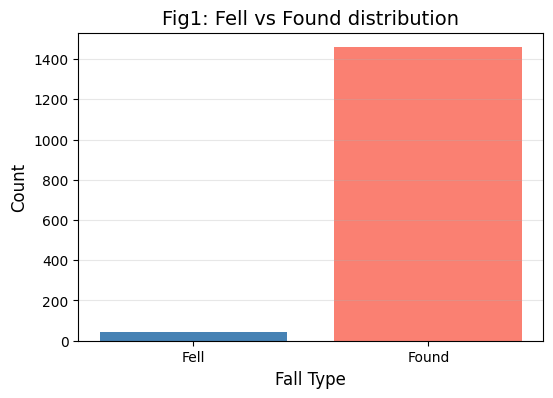

In [3]:
import matplotlib.pyplot as plt
from collections import Counter

fall_counts = Counter(r["fall"] for r in sampled_rows)

plt.figure(figsize=(6,4))
plt.bar(list(fall_counts.keys()), list(fall_counts.values()), color=["steelblue", "salmon"])

plt.title("Fig1: Fell vs Found distribution", fontsize=14)
plt.xlabel("Fall Type", fontsize=12)
plt.ylabel("Count", fontsize=12)
plt.xticks(rotation=0)
plt.grid(axis="y", alpha=0.3)

plt.show()


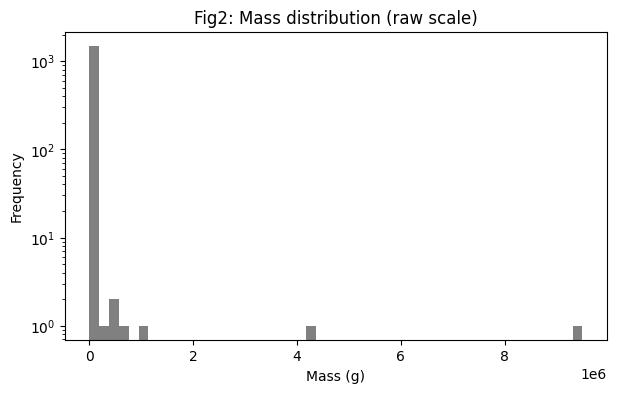

In [4]:
import matplotlib.pyplot as plt

mass_vals = [r["mass"] for r in sampled_rows]

plt.figure(figsize=(7,4))
plt.hist(mass_vals, bins=50, color="gray")
plt.title("Fig2: Mass distribution (raw scale)")
plt.xlabel("Mass (g)")
plt.ylabel("Frequency")
plt.yscale("log")
plt.show()


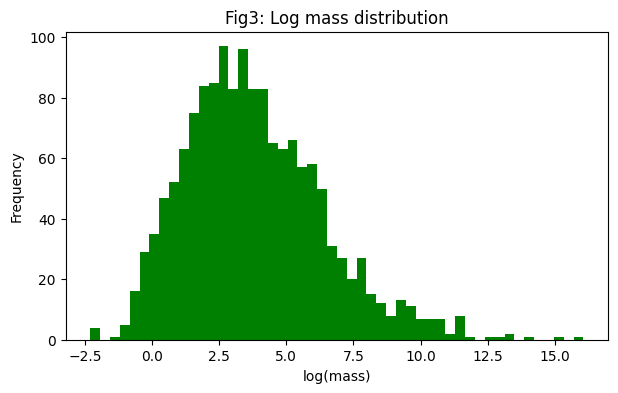

In [5]:
import matplotlib.pyplot as plt

log_mass_vals = [r["log_mass"] for r in sampled_rows]

plt.figure(figsize=(7,4))
plt.hist(log_mass_vals, bins=50, color="green")
plt.title("Fig3: Log mass distribution")
plt.xlabel("log(mass)")
plt.ylabel("Frequency")
plt.show()


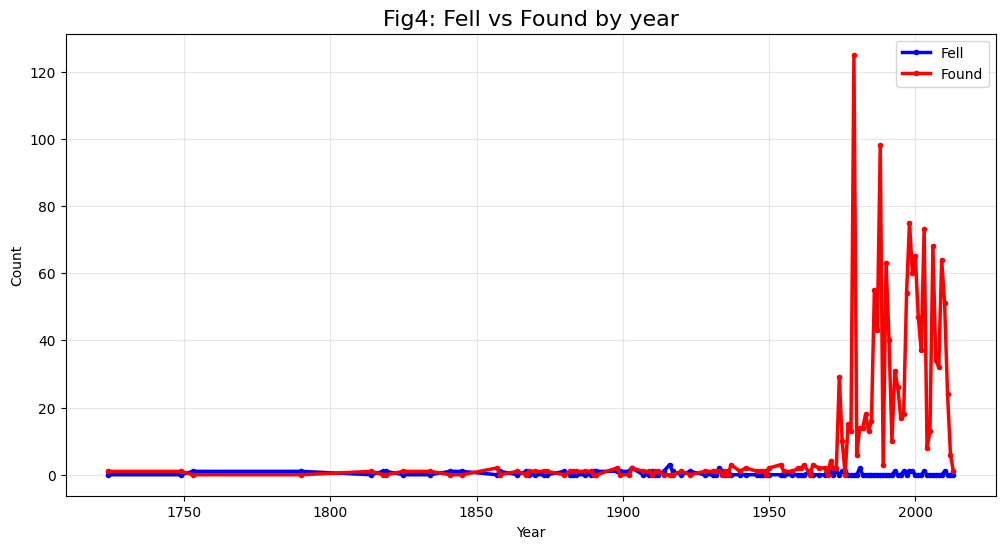

In [6]:
from collections import defaultdict
import matplotlib.pyplot as plt

yearly = defaultdict(lambda: {"Fell": 0, "Found": 0})
for r in sampled_rows:
    yearly[r["year"]][r["fall"]] += 1

years = sorted(yearly.keys())
fell = [yearly[y]["Fell"] for y in years]
found = [yearly[y]["Found"] for y in years]

plt.figure(figsize=(12,6))
plt.plot(years, fell, label="Fell", color="blue", linewidth=2.5, marker="o", markersize=3)
plt.plot(years, found, label="Found", color="red", linewidth=2.5, marker="o", markersize=3)

plt.title("Fig4: Fell vs Found by year", fontsize=16)
plt.xlabel("Year")
plt.ylabel("Count")
plt.legend()
plt.grid(alpha=0.3)
plt.show()


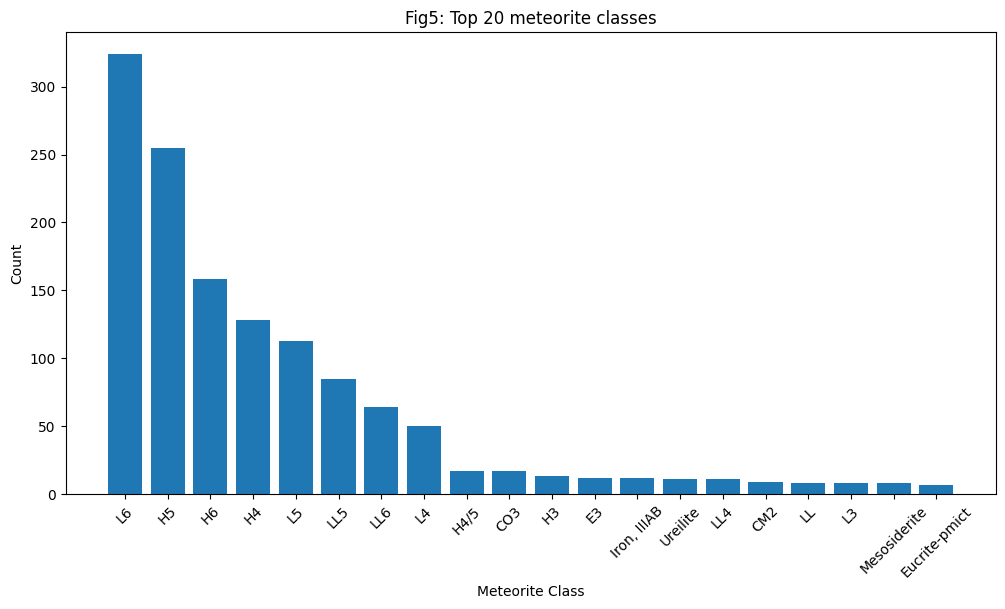

In [7]:
import matplotlib.pyplot as plt
from collections import Counter

rec_counts = Counter(r["recclass"] for r in sampled_rows if r.get("recclass"))
top20 = rec_counts.most_common(20)
classes = [c for c, _ in top20]
values = [v for _, v in top20]

plt.figure(figsize=(12,6))
plt.bar(classes, values)
plt.title("Fig5: Top 20 meteorite classes")
plt.xlabel("Meteorite Class")
plt.ylabel("Count")
plt.xticks(rotation=45)
plt.show()


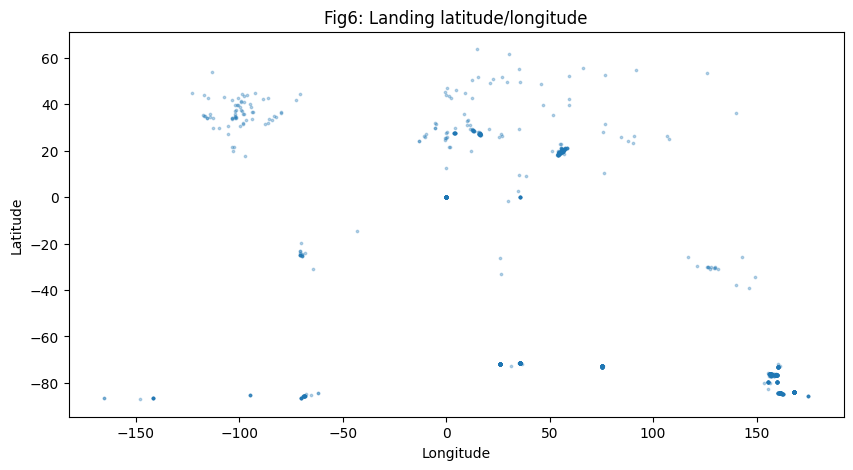

In [8]:
import matplotlib.pyplot as plt

lons = [r["reclong"] for r in sampled_rows]
lats = [r["reclat"] for r in sampled_rows]

plt.figure(figsize=(10,5))
plt.scatter(lons, lats, s=3, alpha=0.3)
plt.title("Fig6: Landing latitude/longitude")
plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.show()


/var/folders/kl/f0zsn9fx4hb4jm5qt7y4m7pc0000gn/T/ipykernel_51466/3831668934.py:7: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot([log_mass_fell, log_mass_found], labels=["Fell", "Found"])


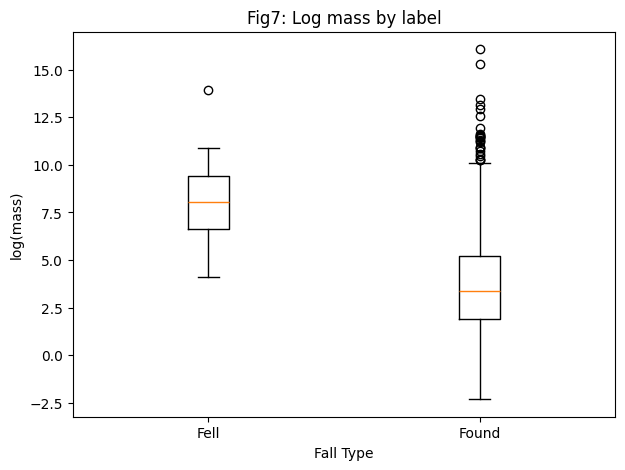

In [9]:
import matplotlib.pyplot as plt

log_mass_fell = [r["log_mass"] for r in sampled_rows if r["fall"] == "Fell"]
log_mass_found = [r["log_mass"] for r in sampled_rows if r["fall"] == "Found"]

plt.figure(figsize=(7,5))
plt.boxplot([log_mass_fell, log_mass_found], labels=["Fell", "Found"])
plt.title("Fig7: Log mass by label")
plt.xlabel("Fall Type")
plt.ylabel("log(mass)")
plt.show()


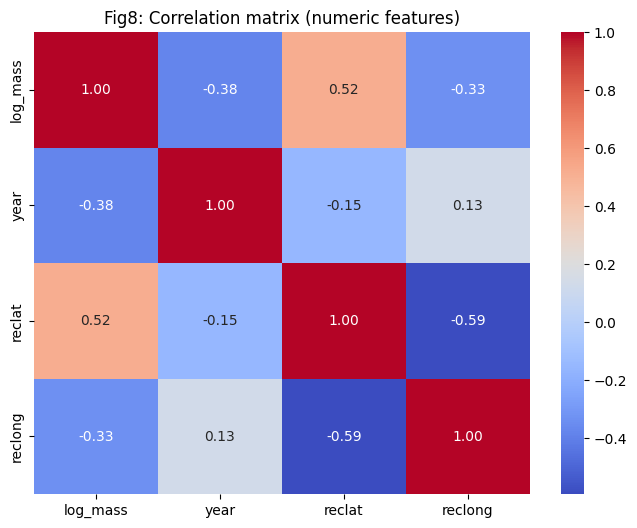

In [10]:
import math
import seaborn as sns
import matplotlib.pyplot as plt

def pearson_corr(x, y):
    mean_x = sum(x) / len(x)
    mean_y = sum(y) / len(y)
    num = sum((a - mean_x) * (b - mean_y) for a, b in zip(x, y))
    den = math.sqrt(sum((a - mean_x) ** 2 for a in x) * sum((b - mean_y) ** 2 for b in y))
    return 0 if den == 0 else num / den

features = ["log_mass", "year", "reclat", "reclong"]
feature_data = {f: [r[f] for r in sampled_rows] for f in features}

corr_matrix = [[pearson_corr(feature_data[a], feature_data[b]) for b in features] for a in features]

plt.figure(figsize=(8,6))
sns.heatmap(corr_matrix, xticklabels=features, yticklabels=features, annot=True, cmap="coolwarm", fmt=".2f")
plt.title("Fig8: Correlation matrix (numeric features)")
plt.show()


In [11]:
# =========================================================
# Phase 4: Feature Engineering (Final Version)
# =========================================================

features = ["log_mass", "year", "reclat", "reclong"]

X = [[row[f] for f in features] for row in sampled_rows]
y = [row["fall"] for row in sampled_rows]

print("X shape:", (len(X), len(features)))
print("y sample:", y[:10])


X shape: (1500, 4)
y sample: ['Fell', 'Fell', 'Fell', 'Fell', 'Fell', 'Fell', 'Fell', 'Fell', 'Fell', 'Fell']


In [12]:
from mysklearn.myrandomforest import MyRandomForestClassifier

# ------------------------------------------------------
# Stratified split: 1/3 test, 2/3 remainder (per course requirement)
# ------------------------------------------------------
rf_splitter = MyRandomForestClassifier(random_state=42)
X_train, X_test, y_train, y_test = rf_splitter.stratified_split(
    X, y, test_ratio=1/3
)

print("Train size:", len(y_train))
print("Test size:", len(y_test))


Train size: 1000
Test size: 500


In [13]:
# Reuse X/y constructed above
print("Total samples:", len(X))
print("Feature count:", len(X[0]) if X else 0)
print("First five labels:", y[:5])


Total samples: 1500
Feature count: 4
First five labels: ['Fell', 'Fell', 'Fell', 'Fell', 'Fell']


In [14]:
from mysklearn.mynaviebayes import MyNaiveBayesClassifier
from mysklearn.myevaluation import accuracy_score, confusion_matrix

nb = MyNaiveBayesClassifier()
nb.fit(X_train, y_train)
pred_nb = nb.predict(X_test)

acc_nb = accuracy_score(y_test, pred_nb)
print("Naive Bayes accuracy:", acc_nb)
print("Naive Bayes Confusion Matrix:", confusion_matrix(y_test, pred_nb))


Naive Bayes accuracy: 0.944
Naive Bayes Confusion Matrix: ([[9, 5], [23, 463]], ['Fell', 'Found'])


In [15]:
from mysklearn.myrandomforest import MyRandomForestClassifier
from mysklearn.myevaluation import accuracy_score, confusion_matrix

param_sets = [
    (10, 5, 2),  # (N, M, F)
    (20, 7, 2),
    (30, 10, 3)
]

rf_results = []
for N, M, F in param_sets:
    rf = MyRandomForestClassifier(
        n_estimators=N,
        top_k=M,
        max_features=F,
        random_state=42
    )
    rf.fit(X_train, y_train)
    preds = rf.predict(X_test)
    acc = accuracy_score(y_test, preds)
    cm = confusion_matrix(y_test, preds)
    rf_results.append({"N": N, "M": M, "F": F, "accuracy": acc, "cm": cm})
    print(f"RF (N={N}, M={M}, F={F}) -> accuracy: {acc:.4f}, confusion: {cm}")

print("Best configs (sorted by current test accuracy):")
rf_results_sorted = sorted(rf_results, key=lambda r: r["accuracy"], reverse=True)
for r in rf_results_sorted:
    print(r)


RF (N=10, M=5, F=2) -> accuracy: 0.9760, confusion: ([[6, 8], [4, 482]], ['Fell', 'Found'])
RF (N=20, M=7, F=2) -> accuracy: 0.9660, confusion: ([[3, 11], [6, 480]], ['Fell', 'Found'])
RF (N=30, M=10, F=3) -> accuracy: 0.9740, confusion: ([[3, 11], [2, 484]], ['Fell', 'Found'])
Best configs (sorted by current test accuracy):
{'N': 10, 'M': 5, 'F': 2, 'accuracy': 0.976, 'cm': ([[6, 8], [4, 482]], ['Fell', 'Found'])}
{'N': 30, 'M': 10, 'F': 3, 'accuracy': 0.974, 'cm': ([[3, 11], [2, 484]], ['Fell', 'Found'])}
{'N': 20, 'M': 7, 'F': 2, 'accuracy': 0.966, 'cm': ([[3, 11], [6, 480]], ['Fell', 'Found'])}


In [16]:
from mysklearn.myclassifiers import MyDummyClassifier

dummy = MyDummyClassifier()
dummy.fit(X_train, y_train)
pred_dummy = dummy.predict(X_test)

acc_dummy = accuracy_score(y_test, pred_dummy)
print("Dummy accuracy:", acc_dummy)
print("Dummy Confusion Matrix:", confusion_matrix(y_test, pred_dummy))


Dummy accuracy: 0.972
Dummy Confusion Matrix: ([[0, 14], [0, 486]], ['Fell', 'Found'])


In [17]:
from mysklearn.myclassifiers import MyKNeighborsClassifier
from mysklearn.mydecisiontree import MyDecisionTreeClassifier
from mysklearn.mynaviebayes import MyNaiveBayesClassifier
from mysklearn.myrandomforest import MyRandomForestClassifier
from mysklearn.myevaluation import accuracy_score

# Handle class imbalance: stratified split + balanced accuracy (mean recall)
def balanced_accuracy(y_true, y_pred):
    labels = sorted(set(y_true))
    recalls = []
    for lbl in labels:
        tp = sum(1 for t, p in zip(y_true, y_pred) if t == lbl and p == lbl)
        positives = sum(1 for t in y_true if t == lbl)
        recalls.append(tp / positives if positives else 0)
    return sum(recalls) / len(recalls)

seeds = [0, 1, 2, 3, 4]

models = {
    "KNN(k=5)": lambda s: MyKNeighborsClassifier(n_neighbors=5),
    "NaiveBayes": lambda s: MyNaiveBayesClassifier(),
    "DecisionTree": lambda s: MyDecisionTreeClassifier(max_features=None, random_state=s),
    "RandomForest(N=20,M=7,F=2)": lambda s: MyRandomForestClassifier(
        n_estimators=20, top_k=7, max_features=2, random_state=s
    ),
}

for name, builder in models.items():
    accs, bals = [], []
    for seed in seeds:
        splitter = MyRandomForestClassifier(random_state=seed)
        X_train, X_test, y_train, y_test = splitter.stratified_split(X, y, test_ratio=1/3)
        model = builder(seed)
        model.fit(X_train, y_train)
        preds = model.predict(X_test)
        accs.append(accuracy_score(y_test, preds))
        bals.append(balanced_accuracy(y_test, preds))
    mean_acc = sum(accs) / len(accs)
    mean_bal = sum(bals) / len(bals)
    var_acc = sum((a - mean_acc) ** 2 for a in accs) / len(accs)
    var_bal = sum((b - mean_bal) ** 2 for b in bals) / len(bals)
    print(f"{name}: acc mean={mean_acc:.4f}, var={var_acc:.6f}; balanced acc mean={mean_bal:.4f}, var={var_bal:.6f}")


KNN(k=5): acc mean=0.9800, var=0.000016; balanced acc mean=0.7539, var=0.004728
NaiveBayes: acc mean=0.9544, var=0.000098; balanced acc mean=0.8378, var=0.001484
DecisionTree: acc mean=0.9724, var=0.000034; balanced acc mean=0.7083, var=0.004087
RandomForest(N=20,M=7,F=2): acc mean=0.9788, var=0.000028; balanced acc mean=0.7185, var=0.002872
